### **ICESat数据预处理**

In [58]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyrsimg import readTiff, imgShow, second_to_dyr


In [59]:
path_glah14 = 'data/laser/GLAH14_634_2109_002_0351_0_01_0001.H5'
path_rsimg = 'data/rsimg/s2_gla_region_20220707.tif'


In [60]:
# !h5ls $path_glah14
# !h5ls $path_glah14/Data_1HZ/Geolocation/i_track
!h5ls $path_glah14/Data_40HZ/Elevation_Surfaces


d_LandVar                Dataset {1137320/Inf}
d_elev                   Dataset {1137320/Inf}
d_refRng                 Dataset {1137320/Inf}


In [61]:
vars_glah14 = {}
with h5py.File(path_glah14,'r') as glah14:
    vars_glah14['lat'] = glah14['Data_40HZ/Geolocation/d_lat'][:]
    vars_glah14['lon'] = glah14['Data_40HZ/Geolocation/d_lon'][:]
    vars_glah14['time'] = glah14['Data_40HZ/Time/d_UTCTime_40'][:]
    vars_glah14['elev'] = glah14['Data_40HZ/Elevation_Surfaces/d_elev'][:]
    ### saturation correction
    vars_glah14['satu_corr'] = glah14['Data_40HZ/Elevation_Corrections/d_satElevCorr'][:]
    vars_glah14['satu_flag'] = glah14['Data_40HZ/Quality/sat_corr_flg'][:]
    ### Delta Ellipsoid (T/P ellipsoid - wgs84 ellipsoid), the glah14 elevation is T/P ellipsoid-based.
    vars_glah14['delta_ellip'] = glah14['Data_40HZ/Geophysical/d_deltaEllip'][:]
    ### quality for data filtering
    vars_glah14['elev_flg'] = glah14['Data_40HZ/Quality/elev_use_flg'][:]  ## 0 is valid, 1 is invalid
    vars_glah14['att_flg'] = glah14['Data_40HZ/Quality/sigma_att_flg'][:]  ## 0 is good...
    print(vars_glah14['lat'].shape)

## 2. remote sensing image
rsimg = readTiff(path_rsimg)
print(rsimg.array.shape)


(1137320,)
(870, 1070, 6)


In [62]:
### time conversion (seconds to decimal year)
### Seconds (from 2000-01-01 00:00:00) to decimal year
print(vars_glah14['time'][0:10])
vars_glah14['time_dyr'] = second_to_dyr(vars_glah14['time'])
print(vars_glah14['time_dyr'][0:10])


[1.52612676e+08 1.52612676e+08 1.52612676e+08 1.52612676e+08
 1.52612676e+08 1.52612677e+08 1.52612677e+08 1.52612677e+08
 1.52612677e+08 1.52612677e+08]
[2004.83429178 2004.83429178 2004.83429178 2004.83429178 2004.83429178
 2004.83429178 2004.83429178 2004.83429179 2004.83429179 2004.83429179]


In [63]:
### Remove values out of region.
ids = np.where((vars_glah14['lat']>30.38) \
                & (vars_glah14['lat']<30.77) \
                & (vars_glah14['lon']<95.04) \
                & (vars_glah14['lon']>94.56))

print(vars_glah14['lat'].shape)
for key in vars_glah14:
  vars_glah14[key] = vars_glah14[key][ids]
print(vars_glah14['lat'].shape)


(1137320,)
(246,)


In [64]:
### Filter out low-quality data
ids = np.where((vars_glah14['elev_flg']==0) & (vars_glah14['att_flg'] == 0) & (vars_glah14['satu_flag']<2))[0]
print(vars_glah14['lat'].shape)
for key in vars_glah14:
  vars_glah14[key] = vars_glah14[key][ids]
print(vars_glah14['lat'].shape)


(246,)
(215,)


In [65]:
## Apply corrections
### Apply saturation filtering
vars_glah14['elev_cor'] = vars_glah14['elev'] + vars_glah14['satu_corr']   ### saturation correction


In [66]:
### Apply conversion from T/P ellipsoid to WGS84
vars_glah14['elev_cor'] = vars_glah14['elev_cor'] - vars_glah14['delta_ellip']


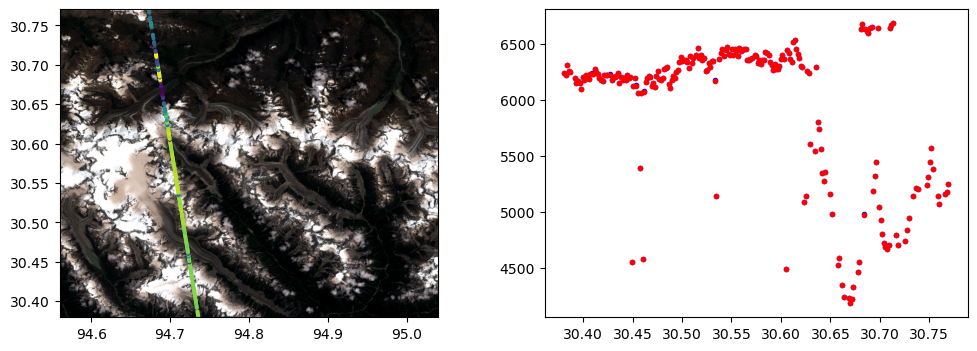

In [67]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
imgShow(rsimg.array, extent=rsimg.geoextent, clip_percent=5, ax=ax[0])
ax[0].scatter(x=vars_glah14['lon'], y=vars_glah14['lat'], c=vars_glah14['elev_cor'], s=3.5)  ## jason data
ax[1].plot(vars_glah14['lat'], vars_glah14['elev'], 'b.')
ax[1].plot(vars_glah14['lat'], vars_glah14['elev_cor'], 'r.',)
# ax[1].set_ylim(4770, 4800)
# ax[1].set_xlim(30.4, 30.6)


In [68]:
## write out to .h5 file.
file_out = 'data/laser/isat_gla_region.h5'
with h5py.File(file_out, "w") as f_out:
    [f_out.create_dataset(key, data=vars_glah14[key]) for key in vars_glah14.keys()]
    print('written file:', (file_out))


written file: data/laser/isat_gla_region.h5
